# DML and Partitioning

As part of this section we will continue understanding further concepts related to DML and also get into the details related to partitioning tables. With respect to DML, earlier we have seen how to use LOAD command, now we will see how to use INSERT command primarily to get query results copied into a table.

* Introduction to Partitioning
* Creating Tables using Parquet
* LOAD vs. INSERT
* Inserting Data using Stage Table
* Creating Partitioned Tables
* Adding Partitions to Tables
* Loading data into Partitions
* Inserting Data into Partitions
* Using Dynamic Partition Mode
* Exercise - Partitioned Tables

**Unlike Hive, Spark SQL does not support Bucketing which is similar to Hash Partitioning. However, Delta Lake does. Delta Lake is 3rd party library which facilitate us additional capabilities such as ACID transactions on top of Spark Metastore tables**

Let us make sure that we have orders table with data as we will be using it to populate partitioned tables very soon.

In [ ]:
val username = System.getProperty("user.name")

In [ ]:
import org.apache.spark.sql.SparkSession

val spark = SparkSession.
    builder.
    config("spark.ui.port", "0").
    config("spark.sql.warehouse.dir", "/user/itversity/warehouse").
    enableHiveSupport.
    appName("Spark SQL - Managing Tables - DML and Partitioning").
    master("yarn").
    getOrCreate

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

SHOW tables

In [ ]:
%%sql

DROP TABLE orders

In [ ]:
%%sql

SELECT current_database()

In [ ]:
%%sql

CREATE TABLE IF NOT EXISTS itversity_retail.orders (
  order_id INT,
  order_date STRING,
  order_customer_id INT,
  order_status STRING
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ','

In [ ]:
%%sql

LOAD DATA LOCAL INPATH '/data/retail_db/orders'
    OVERWRITE INTO TABLE orders

In [ ]:
%%sql

SELECT count(1) FROM orders

## Introduction to Partitioning

Let us get an overview of partitioning of Spark Metastore tables.

* It is similar to list partitioning where each partition is equal to a particular value for a given column.
* Spark Metastore does not support range partitioning and bucketing. Bucketing is supported in Hive which is similar to Hash Partitioning.
* Once the table is created, we can add static partitions and then load or insert data into it.
* Spark Metastore also support creation of partitions dynamically, where partitions will be created based up on the partition column value.
* A Partitioned table can be managed or external.

## Creating Tables using Parquet

Let us create order_items table using Parquet file format. By default, the files of table using Parquet file format are compressed using Snappy algorithm.
* A table with parquet file format can be external.
* In our case we will create managed table with file format as parquet in STORED AS clause.
* We will explore INSERT to insert query results into this table of type parquet.

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

SHOW tables

* Drop order_items, if it already exists

In [ ]:
%%sql

DROP TABLE IF EXISTS order_items

In [ ]:
%%sql

CREATE TABLE order_items (
  order_item_id INT,
  order_item_order_id INT,
  order_item_product_id INT,
  order_item_quantity INT,
  order_item_subtotal FLOAT,
  order_item_product_price FLOAT
) STORED AS parquet

* To get complete output run the below command using `spark-sql`. Here is the output look like.

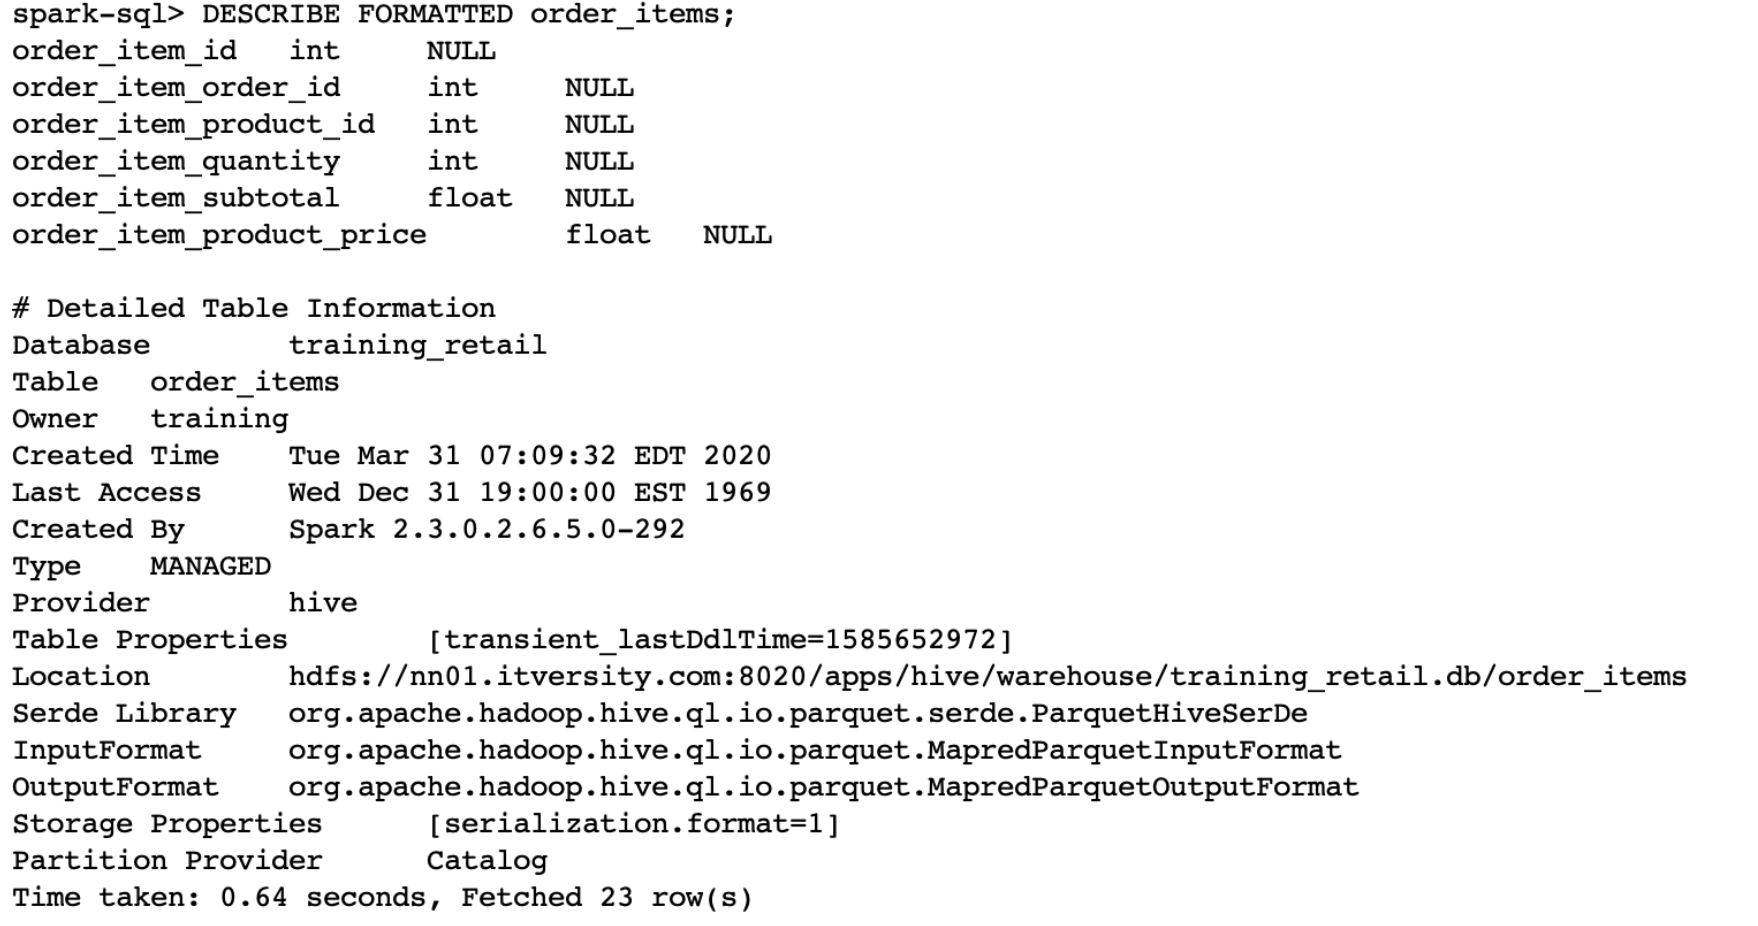

In [ ]:
%%sql

DESCRIBE FORMATTED order_items

In [ ]:
spark.sql("DESCRIBE FORMATTED order_items").show(200, false)

In [ ]:
val username = System.getProperty("user.name")

In [ ]:
import sys.process._

s"hdfs dfs -ls /user/${username}/warehouse/${username}_retail.db/order_items" !

## LOAD vs. INSERT

Let us compare and contrast LOAD and INSERT commands. These are the main approaches using which we get data into Spark Metastore tables.

* LOAD will copy the files by dividing them into blocks.
* LOAD is the fastest way of getting data into Spark Metastore tables. However, there will be minimal validations at File level. 
* There will be no transformations or validations at data level.
* If it require any transformation while getting data into Spark Metastore table, then we need to use INSERT command.
* Here are some of the usage scenarios of insert:
  * Changing delimiters in case of text file format
  * Changing file format
  * Loading data into partitioned or bucketed tables (if bucketing is supported).
  * Apply any other transformations at data level (widely used)

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

DROP TABLE IF EXISTS order_items

In [ ]:
%%sql

CREATE TABLE order_items (
  order_item_id INT,
  order_item_order_id INT,
  order_item_product_id INT,
  order_item_quantity INT,
  order_item_subtotal FLOAT,
  order_item_product_price FLOAT
) STORED AS parquet

In [ ]:
%%sql

LOAD DATA LOCAL INPATH '/data/retail_db/order_items'
    INTO TABLE order_items

In [ ]:
val username = System.getProperty("user.name")

In [ ]:
import sys.process._

s"hdfs dfs -ls /user/${username}/warehouse/${username}_retail.db/order_items" !

In [ ]:
%%sql

SELECT * FROM order_items LIMIT 10

## Inserting Data using Stage Table

Let us understand how to insert data into order_items with Parquet file format. 

As data is in text file format and our table is created with Parquet file format, we will not be able to use LOAD command to load the data.

In [ ]:
%%sql

LOAD DATA LOCAL INPATH '/data/retail_db/order_items'
    OVERWRITE INTO TABLE order_items

* Above load command will be successful, however when we try to query it will fail as the query expects data to be in Parquet file format.

In [ ]:
%%sql

SELECT * FROM order_items LIMIT 10

In [ ]:
%%sql

TRUNCATE TABLE order_items

Following are the steps to get data into table which is created using different file format or delimiter than our source data.

* We need to create stage table with text file format and comma as delimiter (order_items_stage).
* Load data from our files in local file system to stage table.
* Using stage table run insert command to insert data into our target table (order_items).

Let us see an example of inserting data into the target table from staging table.

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

SHOW tables

In [ ]:
%%sql

CREATE TABLE order_items_stage (
  order_item_id INT,
  order_item_order_id INT,
  order_item_product_id INT,
  order_item_quantity INT,
  order_item_subtotal FLOAT,
  order_item_product_price FLOAT
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ','

In [ ]:
spark.sql("DESCRIBE FORMATTED order_items_stage").show(200, false)

In [ ]:
%%sql

LOAD DATA LOCAL INPATH '/data/retail_db/order_items' INTO TABLE order_items_stage

In [ ]:
%%sql

SELECT * FROM order_items_stage LIMIT 10

In [ ]:
%%sql

TRUNCATE TABLE order_items

In [ ]:
%%sql

INSERT INTO TABLE order_items
SELECT * FROM order_items_stage

In [ ]:
%%sql

SELECT * FROM order_items LIMIT 10

In [ ]:
%%sql

SELECT count(1) FROM order_items

* `INSERT INTO` will append data into the target table by adding new files.

In [ ]:
%%sql

INSERT INTO TABLE order_items
SELECT * FROM order_items_stage

In [ ]:
%%sql

SELECT * FROM order_items LIMIT 10

In [ ]:
%%sql

SELECT count(1) FROM order_items

* `INSERT OVERWRITE` will overwrite the data in target table by deleting the files related to old data from the directory pointed by the Spark Metastore table.

In [ ]:
%%sql

INSERT OVERWRITE TABLE order_items
SELECT * FROM order_items_stage

In [ ]:
%%sql

SELECT * FROM order_items

In [ ]:
%%sql

SELECT count(1) FROM order_items

In [ ]:
import sys.process._

s"hdfs dfs -ls /user/${username}/warehouse/${username}_retail.db/order_items" !

## Creating Partitioned Tables

Let us understand how to create partitioned table and get data into that table.

* Earlier we have already created orders table. We will use that as reference and create partitioned table.
* We can use `PARTITIONED BY` clause to define the **column along with data type**. In our case we will use **order_month as partition column**.
* We will not be able to directly load the data into the partitioned table using our original orders data (as data is not in sync with structure).

Here is the example of creating partitioned tables in Spark Metastore.

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

SHOW tables

* Drop orders_part if it already exists

In [ ]:
%%sql

DROP TABLE IF EXISTS orders_part

In [ ]:
%%sql

CREATE TABLE orders_part (
  order_id INT,
  order_date STRING,
  order_customer_id INT,
  order_status STRING
) PARTITIONED BY (order_month INT)
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','

In [ ]:
%%sql

DESCRIBE orders_part

In [ ]:
spark.sql("DESCRIBE FORMATTED orders_part").show(200, false)

In [ ]:
import sys.process._

s"hdfs dfs -ls /user/${username}/warehouse/${username}_retail.db/orders_part" !

## Adding Partitions to Tables

Let us understand how we can add static partitions to Partitioned tables in Spark Metastore.

* We can add partitions using `ALTER TABLE` command with `ADD PARTITION`.
* For each and every partition created, a subdirectory will be created using partition column name and corresponding value under the table directory.
* Let us understand how to add partitions to **orders_part** table under **itversity_retail** database.

> Here is the script to add static partitions to a Partitioned table where partition column type is string.

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

DROP TABLE IF EXISTS orders_part

In [ ]:
%%sql

CREATE TABLE orders_part (
  order_id INT,
  order_date STRING,
  order_customer_id INT,
  order_status STRING
) PARTITIONED BY (order_month STRING)
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','

In [ ]:
import sys.process._

s"hdfs dfs -ls /user/${username}/warehouse/${username}_retail.db/orders_part" !

In [ ]:
%%sql

ALTER TABLE orders_part ADD PARTITION (order_month='2013-07')

In [ ]:
import sys.process._

s"hdfs dfs -ls /user/${username}/warehouse/${username}_retail.db/orders_part" !

> Here is the script to add static partitions to a Partitioned table where partition column type is integer. We can add one or more partitions at a time. For further demos we will be using this table

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

DROP TABLE IF EXISTS orders_part

In [ ]:
%%sql

CREATE TABLE orders_part (
  order_id INT,
  order_date STRING,
  order_customer_id INT,
  order_status STRING
) PARTITIONED BY (order_month INT)
ROW FORMAT DELIMITED FIELDS TERMINATED BY ','

In [ ]:
%%sql

DESCRIBE orders_part

In [ ]:
import sys.process._

s"hdfs dfs -ls /user/${username}/warehouse/${username}_retail.db/orders_part" !

In [ ]:
%%sql

ALTER TABLE orders_part ADD PARTITION (order_month=201307)

In [ ]:
%%sql

ALTER TABLE orders_part ADD
    PARTITION (order_month=201308)
    PARTITION (order_month=201309)
    PARTITION (order_month=201310)

In [ ]:
import sys.process._

s"hdfs dfs -ls /user/${username}/warehouse/${username}_retail.db/orders_part" !

## Loading into Partitions

Let us understand how to use load command to load data into partitioned tables.

* We need to make sure that file format of the file which is being loaded into table is same as the file format used while creating the table.
* We also need to make sure that delimiters are consistent between files and table for text file format.
* Also data should match the criteria for the partition into which data is loaded.
* Our `/data/retail_db/orders` have data for the whole year and hence we should not load the data directly into partition.
* We need to split into files matching partition criteria and then load into the table.

To use load command to load the files into partitions we need to pre-partition the data based on partition logic. 

Here is the example of using simple shell commands to partition the data. Use command prompt to run these commands


```shell
rm -rf ~/orders
mkdir -p ~/orders

grep 2013-07 /data/retail_db/orders/part-00000 > ~/orders/orders_201307
grep 2013-08 /data/retail_db/orders/part-00000 > ~/orders/orders_201308
grep 2013-09 /data/retail_db/orders/part-00000 > ~/orders/orders_201309
grep 2013-10 /data/retail_db/orders/part-00000 > ~/orders/orders_201310
```

Let us see how we can load data into corresponding partitions. Data has to be pre-partitioned based on the partitioned column.

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

LOAD DATA LOCAL INPATH '/home/itversity/orders/orders_201307'
  INTO TABLE orders_part PARTITION (order_month=201307)

In [ ]:
import sys.process._

s"hdfs dfs -ls -R /user/${username}/warehouse/${username}_retail.db/orders_part" !

In [ ]:
%%sql

LOAD DATA LOCAL INPATH '/home/itversity/orders/orders_201308'
  INTO TABLE orders_part PARTITION (order_month=201308)

In [ ]:
%%sql

LOAD DATA LOCAL INPATH '/home/itversity/orders/orders_201309'
  INTO TABLE orders_part PARTITION (order_month=201309)

In [ ]:
%%sql

LOAD DATA LOCAL INPATH '/home/itversity/orders/orders_201310'
  INTO TABLE orders_part PARTITION (order_month=201310)

In [ ]:
import sys.process._

s"hdfs dfs -ls -R /user/${username}/warehouse/${username}_retail.db/orders_part" !

In [ ]:
import sys.process._

s"hdfs dfs -tail /user/${username}/warehouse/${username}_retail.db/orders_part/order_month=201310/orders_201310"!

In [ ]:
%%sql

SELECT * FROM orders_part LIMIT 10

## Inserting Data into Partitions

Let us understand how to use insert to get data into static partitions in Spark Metastore from existing table called as orders.

* Let us recap what is covered so far related to partitioned tables.
  * We have created a table called as orders_part with order_month of type INT as partitioned column.
  * We have added 4 static partitions for 201307, 201308, 201309 and 201310 using ALTER TABLE command.
  * Once the table is created and partitions are added we have pre-processed the data to get data into the partitions using LOAD command.
* It is not practical to use LOAD command always. We typically use `INSERT` via stage table to copy data into partitioned table.
* We can pre-create partitions in partitioned tables and insert data into partitions using appropriate `INSERT `command. One need to ensure that required filter condition is applied to get the data relevant to the partition that is being populated.
* We can also create partitions dynamically which we will see as part of the next topic.

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

ALTER TABLE orders_part ADD PARTITION (order_month=201311)

In [ ]:
%%sql

SELECT count(1) FROM orders_part

In [ ]:
%%sql

INSERT INTO TABLE orders_part PARTITION (order_month=201311)
  SELECT * FROM orders WHERE order_date LIKE '2013-11%'

In [ ]:
%%sql

SELECT count(1) FROM orders_part

In [ ]:
import sys.process._

s"hdfs dfs -ls -R /user/${username}/warehouse/${username}_retail.db/orders_part" !

## Using Dynamic Partition Mode

Let us understand how we can insert data into partitioned table using dynamic partition mode.

* Using dynamic partition mode we need not pre create the partitions. Partitions will be automatically created when we issue INSERT command in dynamic partition mode.
* To insert data using dynamic partition mode, we need to set the property `hive.exec.dynamic.partition` to **true**
* Also we need to set `hive.exec.dynamic.partition.mode` to **nonstrict**

Here is the example of inserting data into partitions using dynamic partition mode.

In [ ]:
%%sql

USE itversity_retail

In [ ]:
%%sql

SHOW tables

In [ ]:
%%sql

SELECT count(1) FROM orders

In [ ]:
%%sql

SELECT count(1) FROM orders_part

In [ ]:
%%sql

SET hive.exec.dynamic.partition

In [ ]:
%%sql

SET hive.exec.dynamic.partition.mode

In [ ]:
%%sql

SET hive.exec.dynamic.partition=true

In [ ]:
%%sql

SET hive.exec.dynamic.partition.mode=nonstrict

In [ ]:
%%sql

INSERT INTO TABLE orders_part PARTITION (order_month)
SELECT o.*, date_format(order_date, 'yyyyMM') order_month
FROM orders o
WHERE order_date >= '2013-12-01 00:00:00.0'

In [ ]:
import sys.process._

s"hdfs dfs -ls -R /user/${username}/warehouse/${username}_retail.db/orders_part" !

In [ ]:
%%sql

SELECT count(1) FROM orders

In [ ]:
%%sql

SELECT count(1) FROM orders_part

* You will see new partitions created starting from 201312 to 201407.

## Exercise - Partitioned Tables

Let us take care of this exercise related to partitioning to self evaluate our comfort level in working with partitioned tables.

* Duration: **30 Minutes**
* Use data from **/data/nyse_all/nyse_data**
* Use database **YOUR_OS_USER_NAME_nyse**
* Create partitioned table **nyse_eod_part**
* Field Names: stockticker, tradedate, openprice, highprice, lowprice, closeprice, volume
* Determine correct data types based on the values
* Create Managed table with "," as delimiter.
* Partition Field should be **tradeyear** and of type **INT** (one partition for corresponding year)
* Insert data into partitioned table using dynamic partition mode.
* Here are the steps to come up with the solution.
  * Review the files under **/data/nyse_all/nyse_data** - determine data types (For example: tradedate should be INT and volume should be BIGINT)
  * Create database **YOUR_OS_USER_NAME_nyse** (if it does not exists)
  * Create non partitioned stage table
  * Load data into non partitioned stage table
  * Validate the count and also see that data is as expected by running simple select query.
  * Create partitioned table
  * Set required properties to use dynamic partition
  * Insert data into partitioned table - here is how you can compute year from tradedate of type int `year(to_date(cast(tradedate AS STRING), 'yyyyMMdd')) AS tradeyear`
  * Run below validate commands to validate

### Validation
Here are the instructions to validate the results.
* Run `hdfs dfs -ls /user/YOUR_OS_USER_NAME/warehouse/YOUR_OS_USER_NAME_nyse.db/nyse_eod_part`
* Run `SHOW PARTITIONS YOUR_OS_USER_NAME_nyse.nyse_eod_part`. You should see partitions for all the years using which you have loaded the data.
* Run `SELECT count(1) FROM YOUR_OS_USER_NAME_nyse.nyse_eod_part`. The count should match the number of records in our dataset.
* You can compare with the output generated by this simple Python code which is validated in our labs.

```
import pandas as pd
import glob

path = r'/data/nyse_all/nyse_data' # use your path
all_files = glob.glob(path + "/*.txt.gz")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.shape
```